# Data Dive Week 5: Regression in Python

Note that this notebook borrows heavily from the [online resources](https://github.com/cs109/2015lab4) for [CS109 at Harvard University](http://cs109.github.io/2015/pages/videos.html). 

***
This week we take a look at some basic statistical concepts, with a particular focus on regression models. As we covered in the [lecture portion](https://grantmlong.com/teaching/spring2019/lectures/lecture5.html) of this week's class, linear regression is used to model and predict continuous outcomes. Time permitting, we'll also discuss logistic regression, which is used to model binary outcomes.

***

Though the DataCamp course covered for homework used the `numpy` package for linear regression, we'll also touch upon `statsmodels` and `scikit-learn` in today's exercise.
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset $X$ and $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $X_i$ without a $Y$ value.  </li>
  <li> Model the <b>strength of the relationship</b> between each dependent variable $X_i$ and $Y$</li>
    <ul>
      <li> Sometimes not all $X_i$ will have a relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to determine $Y$ </li>
    </ul>
</ul>
</div>

### A brief recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is linearly related to the dependent variable $Y$.  

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. This is the simplest form of linear regression (one variable), we'll call this the simple model. 

* $\beta_0$ is the intercept of the linear model

* Multiple linear regression is when you have more than one independent variable
    * $X_1$, $X_2$, $X_3$, $\ldots$

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 



***

![SE](https://press.streeteasy.com/image/StreetEasy_Horizontal_Ink_RGB.jpg)

# StreetEasy Rentals Data Set

Data from this week's exercise comes from [StreetEasy](www.streeteasy.com), an online platform for real estate listings in New York City. The sample provided covers 12,000 listings for homes for rent across NYC in the summer of  2018 and provides several features of interest in modeling rents, including neighborhood, subway access, building amenities, building age.


Note that this data is provided for instructional purposes only and is not intended to be representative of all listings on StreetEasy or all homes for rent in New York City. Any analysis conducted as part of this exercise does not reflect the opinion or endorsement of StreetEasy or any of its affiliates.  


In [2]:
raw_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)


In [3]:
raw_df.sample(5).transpose()

rental_id,7320454,7339444,7240315,7151188,7289569
addr_unit,#44P,#10A,#7F,#1F,#7C
building_id,52861,81298,1392949,1500250,48457
bedrooms,3,1,1,5,0
bathrooms,3,1,1,2,1
size_sqft,2603,1800,750,1500,550
created_at,2018-06-29 16:04:50,2018-07-06 14:38:26,2018-06-05 13:15:06,2018-05-06 11:55:34,2018-06-20 06:27:24
addr_street,322 WEST 57TH STREET,1000 PARK AVENUE,103-19 68 ROAD,10-34 WYCKOFF AVENUE,240 EAST 35 STREET
addr_city,New York,New York,Forest Hills,Ridgewood,New York
addr_zip,10019,10028,11375,11385,10016
addr_lat,40.7668,40.7792,40.7255,40.6952,40.7455


# Data Exploration

### Summarize and Plot a Histogram for the Target Variable

Is there anything surprising or interesting about this data?

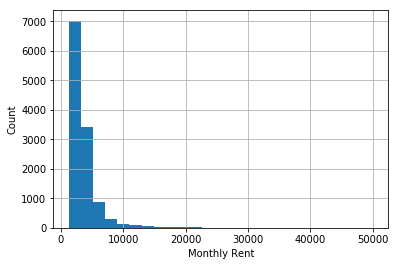

In [4]:
_ = raw_df.rent.hist(bins=25)
_ = plt.xlabel('Monthly Rent')
_ = plt.ylabel('Count')

In [5]:
raw_df.describe()

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,...,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
count,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,1.199900e+04,1.200000e+04,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,10723.000000
mean,1.529133e+06,1.657667,1.239500,850.465750,10682.779667,40.727507,-73.956837,2.370093e+06,2.287120e+09,10.266608,...,0.271667,0.170000,0.264083,0.208583,0.073167,0.132083,0.090500,3605.762917,0.490000,6.182738
std,4.301123e+06,1.079771,0.560208,515.773101,593.370964,0.053241,0.043024,1.242919e+06,1.202105e+09,12.019787,...,0.444837,0.375648,0.440862,0.406313,0.260421,0.338595,0.286909,2897.069446,0.499921,7.671545
min,7.300000e+01,0.000000,0.000000,0.000000,10001.000000,40.573898,-74.141570,1.000000e+06,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,0.000000,0.000000
25%,6.209200e+04,1.000000,1.000000,610.000000,10023.000000,40.693256,-73.986076,1.052139e+06,1.011220e+09,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2250.000000,0.000000,2.000000
50%,2.495815e+05,2.000000,1.000000,800.000000,11103.000000,40.729028,-73.961700,3.019358e+06,3.006580e+09,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2900.000000,0.000000,3.000000
75%,8.225132e+05,2.000000,1.000000,1000.000000,11218.000000,40.764599,-73.936663,3.326098e+06,3.050580e+09,12.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,1.000000,6.000000
max,1.877210e+07,8.000000,20.000000,10000.000000,11694.000000,40.909842,-73.730550,5.158986e+06,5.010640e+09,90.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50000.000000,1.000000,78.000000


### Feature Exploration
##### If we wanted to try to create a model to price any given apartment, what variables might be the most important?
* How many variables are at our disposal?
* Which are binary? Categorical? Continuous? 
* Which variable make most sense to use from an intuitive standpoint?
* Identify which variable(s) has the highest correlation with rents. Do these make sense?


In [6]:
print(list(raw_df))
print()

raw_df.describe()

['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat', 'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden', 'has_childrens_playroom', 'rent', 'no_fee', 'description', 'neighborhood', 'borough', 'unit', 'floornumber', 'line']



,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,...,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
count,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,1.199900e+04,1.200000e+04,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,10723.000000
mean,1.529133e+06,1.657667,1.239500,850.465750,10682.779667,40.727507,-73.956837,2.370093e+06,2.287120e+09,10.266608,...,0.271667,0.170000,0.264083,0.208583,0.073167,0.132083,0.090500,3605.762917,0.490000,6.182738
std,4.301123e+06,1.079771,0.560208,515.773101,593.370964,0.053241,0.043024,1.242919e+06,1.202105e+09,12.019787,...,0.444837,0.375648,0.440862,0.406313,0.260421,0.338595,0.286909,2897.069446,0.499921,7.671545
min,7.300000e+01,0.000000,0.000000,0.000000,10001.000000,40.573898,-74.141570,1.000000e+06,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,0.000000,0.000000
25%,6.209200e+04,1.000000,1.000000,610.000000,10023.000000,40.693256,-73.986076,1.052139e+06,1.011220e+09,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2250.000000,0.000000,2.000000
50%,2.495815e+05,2.000000,1.000000,800.000000,11103.000000,40.729028,-73.961700,3.019358e+06,3.006580e+09,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2900.000000,0.000000,3.000000
75%,8.225132e+05,2.000000,1.000000,1000.000000,11218.000000,40.764599,-73.936663,3.326098e+06,3.050580e+09,12.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,1.000000,6.000000
max,1.877210e+07,8.000000,20.000000,10000.000000,11694.000000,40.909842,-73.730550,5.158986e+06,5.010640e+09,90.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50000.000000,1.000000,78.000000


In [7]:
raw_df.corr()['rent'].sort_values(ascending=False)[1:]

size_sqft                 0.649984
bathrooms                 0.611987
bedrooms                  0.353337
has_washer_dryer          0.343123
has_doorman               0.273486
floornumber               0.267151
has_concierge             0.260079
floor_count               0.253517
has_gym                   0.248213
has_elevator              0.238692
has_childrens_playroom    0.193130
has_dishwasher            0.187002
has_roofdeck              0.174243
has_pool                  0.170412
has_fireplace             0.163483
allows_pets               0.149247
has_garden                0.138419
is_furnished              0.133343
addr_lat                  0.109536
has_garage                0.095437
min_to_subway             0.000010
year_built               -0.001037
no_fee                   -0.001163
building_id              -0.035145
addr_lon                 -0.262711
addr_zip                 -0.325241
bin                      -0.332165
bbl                      -0.339157
Name: rent, dtype: f

### Scatterplots
* Create a scatterplot of `size_sqft`, `bathrooms`, and `floor`.  
* Describe the relationship you see? Is it positive or negative? Linear? Non-linear? 

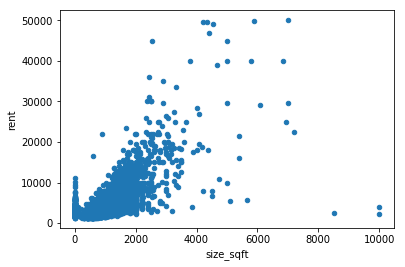

In [8]:
_ = raw_df.plot.scatter('size_sqft', 'rent')

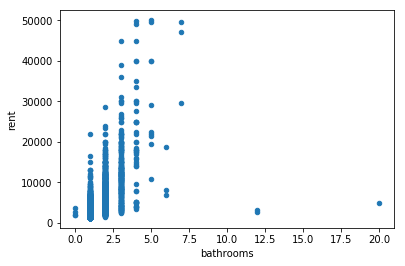

In [9]:
_ = raw_df.plot.scatter('bathrooms', 'rent')

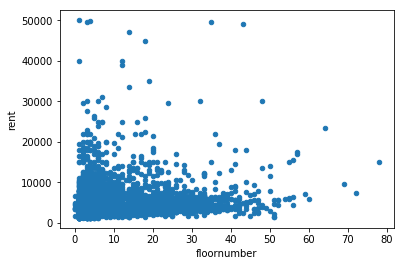

In [10]:
_ = raw_df.plot.scatter('floornumber', 'rent')

# Handling Missing Values

To keep the modeling process clean, let's drop the rows for which we don't have observed values for `year_built`, `floornumber` or `min_to_subway` and create a new df called `se_df`. 

In [11]:
se_df = raw_df.loc[
    raw_df.min_to_subway.notnull() & 
    raw_df.floornumber.notnull() & 
    raw_df.year_built.notnull()
]

print(raw_df.shape)
print(se_df.shape)

(12000, 38)
(10222, 38)


# Modeling
### Single Variable Linear Regression with `size_sqft`
* Use `numpy` to fit a simple linear regression
  - Calculate the slope and intercept using the `polyfit` function
  - Print the slope and intercept. How would you interpret these two numbers?
  - Based on this data, how much would expect a 700 square foot apartment to cost?
  

In [12]:
beta, alpha = np.polyfit(se_df.size_sqft, se_df.rent, 1)
print('beta: %0.3f, alpha: %0.1f.' % (beta, alpha))
print()

beta: 3.703, alpha: 503.9.



In [13]:
print('Based on this analysis a 700 square foot apartment would rent for $%0.2f' 
      % (beta * 700 + alpha))

Based on this analysis a 700 square foot apartment would rent for $3095.81


##### Visualize the relationship. 
  - Plot the fitted line along with the scatter plot.
  - Is this line a good fit?

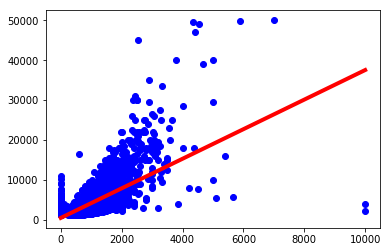

In [14]:
_ = plt.plot(se_df.size_sqft, se_df.rent, color='blue', marker='.', markersize=12, linestyle='none')
_ = plt.plot([0, 10000], [alpha, alpha + beta * 10000],  color='red', linewidth=4)
_ = plt.title('')


In [15]:
se_df.size_sqft.describe()

count    10222.000000
mean       848.000098
std        491.050070
min          0.000000
25%        612.250000
50%        800.000000
75%       1000.000000
max      10000.000000
Name: size_sqft, dtype: float64

##### Calculate the predicted rent and residual for each observation. 
  - Create columns in the `se_df` dataframe for `rent_predicted` and `rent_residual` 
  - Does this appear to fall in line with the assumptions we've described? 

In [16]:
se_df['rent_predicted'] = se_df['rent'] * beta + alpha
se_df['rent_residual'] = se_df['rent_predicted'] - se_df['rent']


/Users/grant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/grant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


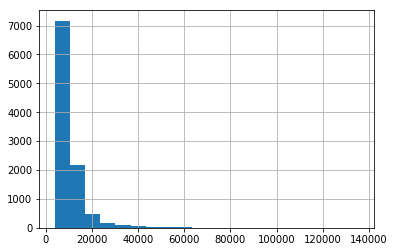

In [17]:
se_df['rent_residual'].hist(bins=20)

### Using `statsmodels` for Single Variable Linear Regression
* Use `statsmodels` to fit a simple linear regression with `size_sqft`.
  - Output the regression results. 
  - Describe how this output compares to our $\alpha$ and $\beta$ from `numpy`.

In [18]:
# Add a constant to our existing dataframe for modeling purposes
se_df = sm.add_constant(se_df)

est = sm.OLS(se_df['rent'], 
             se_df[['const', 'size_sqft']]
            ).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     7196.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:51:25   Log-Likelihood:                -93019.
No. Observations:               10222   AIC:                         1.860e+05
Df Residuals:                   10220   BIC:                         1.861e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        503.8951     42.772     11.781      0.0

/Users/grant/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


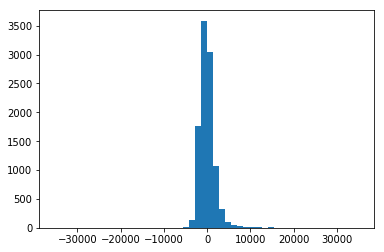

In [19]:
_ = plt.hist(est.resid, bins=50)

### Using `statsmodels` for Multiple Linear Regression
* Still using `statsmodels`, add some variables to our exisiting regression. Can you get a better prediction?
  - Add a one or two variables at a time. What happens to our $R^2$?
  - Which variables are most significant? How does this change as we add more predictors?
  - With regression with many predictors, create a histogram of the residuals. How does this compare to the single variable case?
    * *Note: use can access the residuals using the* `est.resid` *attribute of the regression results.*

In [20]:
est = sm.OLS(se_df['rent'], 
             se_df[['const', 'size_sqft', 'bathrooms']]
            ).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     5726.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:51:26   Log-Likelihood:                -91902.
No. Observations:               10222   AIC:                         1.838e+05
Df Residuals:                   10219   BIC:                         1.838e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1139.8907     50.519    -22.563      0.0

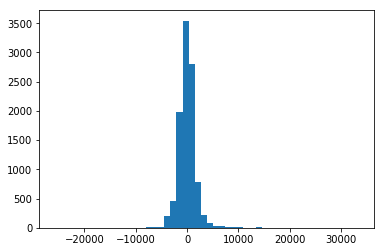

In [21]:
_ = plt.hist(est.resid, bins=50)

### Using `sklearn` for Multiple Linear Regression
`sklearn` is among the most popular packages for machine learning, and it's one we'll be using throughout the rest of the semester. It's syntax and functionality is a little different, but it gives us a little more flexibility around accessing and using the output, and also plays nice with modeling options beyond linear regression. 


In [22]:
# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### What can you do with a LinearRegression object? 

In [23]:
# Look inside linear regression object
# LinearRegression.<tab>

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?


In [24]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

#### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [25]:
# Use sensible subset of predictors to fit linear regression model
dependent_vars = ['bedrooms', 'bathrooms', 'min_to_subway', 'floornumber', 
                  'year_built', 'no_fee', 'has_roofdeck', 
                  'has_washer_dryer', 'has_doorman', 'has_elevator', 
                  'has_dishwasher', 'has_gym']

X = se_df[dependent_vars]

lm.fit(X, se_df.rent)

# notice fit_intercept=True and normalize=True
# How would you change the model to not fit an intercept term? 


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [26]:
print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))

Estimated intercept coefficient: -529.5557827712441
Number of coefficients: 12


In [27]:
# The coefficients
pd.DataFrame(lm.coef_, index=dependent_vars,  columns = ['Est. Coefficient'])

,Est. Coefficient
bedrooms,438.354496
bathrooms,2676.142452
min_to_subway,-0.015903
floornumber,40.372769
year_built,-0.316852
no_fee,-560.758600
has_roofdeck,-84.019830
has_washer_dryer,744.387669
has_doorman,712.221810
has_elevator,614.264796


#### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [28]:
# first five predicted prices
lm.predict(X)[0:5]

array([ 3876.38195586, 10448.90103482,  3775.10814004,  2410.13545848,
        3068.92456051])

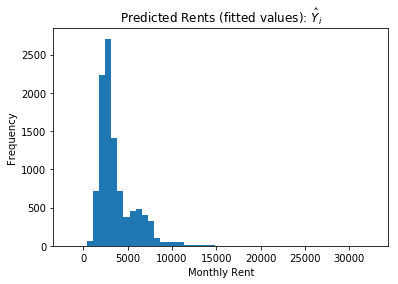

In [29]:
_ = plt.hist(lm.predict(X), bins=50)
_ = plt.title('Predicted Rents (fitted values): $\hat{Y}_i$')
_ = plt.xlabel('Monthly Rent')
_ = plt.ylabel('Frequency')

Let's plot the true prices compared to the predicted prices to see they disagree, we saw this exactly befor but this is how you access the predicted values in using `sklearn`.

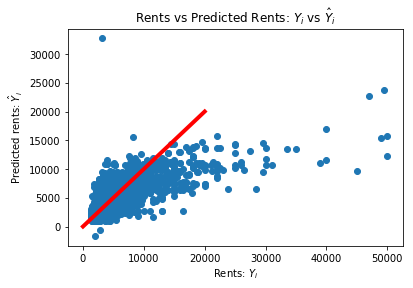

In [30]:
_ = plt.scatter(se_df['rent'], lm.predict(X))
_ = plt.xlabel("Rents: $Y_i$")
_ = plt.ylabel("Predicted rents: $\hat{Y}_i$")
_ = plt.title("Rents vs Predicted Rents: $Y_i$ vs $\hat{Y}_i$")
_ = plt.plot([0, 20000], [0, 20000], linewidth=4, color='red')

### Residual sum of squares

Let's calculate the residual sum of squares 

$$ S = \sum_{i=1}^N r_i = \sum_{i=1}^N (y_i - (\beta_0 + \beta_1 x_i))^2 $$

In [31]:
print('%0.2f' %  np.sum((se_df['rent'] - lm.predict(X)) ** 2))

39550735448.32


# Setting a Benchmark for Performance 

We are not purely limited to the performance metrics provided by the a standard regression output. In some cases, we may wish to have alternative metrics, such as mean squared error: the arithmetic mean of squared difference between the predicted and actual values. 

Doing this can give us a good benchmark to evaluate the predictive performance of the model. 

In [32]:
X = se_df[['bedrooms', 'bathrooms', 'size_sqft']]

lm.fit(X, se_df.rent)
predicted = lm.predict(X)
deviation = predicted - se_df.rent.values
deviation_sq = deviation**2

print('Mean squared error (MSE) for simple model: %0.2f' % np.mean(deviation_sq))

Mean squared error (MSE) for simple model: 3704434.97


### We can also calculate the same metric for test data from August

To see how well our model might predict future rents, we can also apply it to data from August 2018 rents. Did we do a good job?

In [33]:
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)

test_df.sample(5)

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,addr_lat,...,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
rental_id,,,,,,,,,,,,,,,,,,,,,
7436674,#5B,161503,1,1.0,586.0,2018-08-02 16:36:11,577 BALTIC STREET,Brooklyn,11217,40.681301,...,0,0,3100,1,Common Baltic is a brand new building that fea...,Boerum Hill,Brooklyn,5B,5.0,B
7499047,#2F,205762,3,2.0,1600.0,2018-08-22 00:10:27,126 BERKELEY PLACE,Brooklyn,11217,40.675409,...,1,1,5995,0,3 bedroom duplex apartment \r\nPrivate garden\...,Park Slope,Brooklyn,2F,2.0,F
7511941,#1B,539476,2,1.0,1200.0,2018-08-27 00:27:19,785 EAST 34 STREET,Brooklyn,11210,40.637182,...,1,0,2400,1,Rent Directly! No Fee! \r\nNo reasonable offer...,East Flatbush,Brooklyn,1B,1.0,B
7516552,#2L,380434,1,1.0,750.0,2018-08-28 13:40:37,263 POWERS STREET,Brooklyn,11211,40.713295,...,0,0,2295,1,*No Fee*\r\n\r\nNewly renovated King Sized 1 b...,Williamsburg,Brooklyn,2L,2.0,L
7508803,#8,351550,1,1.0,1000.0,2018-08-24 16:59:42,158 NORTH 4 STREET,Brooklyn,11211,40.715588,...,0,0,5687,1,NO FEE! Huge loft available in the heart of Wi...,Williamsburg,Brooklyn,8,NaN,NaN


In [34]:
predicted = lm.predict(test_df[['bedrooms', 'bathrooms', 'size_sqft']])
deviation = predicted - test_df.rent.values
deviation_sq = deviation**2

print('Mean squared error (MSE) for test data model: %0.2f' % np.mean(deviation_sq))

Mean squared error (MSE) for test data model: 4226362.68
